In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import numpy as np
import os


In [2]:
def find_dat_file(directory):
    
    files = os.listdir(directory)
    
    dat_files = [f for f in files if f.endswith('.dat')]

    if len(dat_files) > 1:
        print(f"Multiple .dat files found: {dat_files}")

    if len(dat_files) == 0:
        print("No .dat files found in the directory.")

    return dat_files[0]

In [3]:
def set_path(file_path):

    file_name = find_dat_file(f'C:\\Users\\51325\\Desktop\\2024_summer_caltech\\{file_path}')

    fictrac_path = f'C:\\Users\\51325\\Desktop\\2024_summer_caltech\\{file_path}\\{file_name}'

    stimuli_path = f'C:\\Users\\51325\\Desktop\\2024_summer_caltech\\{file_path}\\log_test.txt'
    
    return fictrac_path, stimuli_path

In [4]:
def get_velocity_pos(fictrac_file_path):
    
    fictrac_file = pd.read_csv(fictrac_file_path, delimiter=',', header=None)

    # Extracting the x,y position
    x_pos = fictrac_file[14]
    y_pos = fictrac_file[15]

    plt.scatter(y_pos,x_pos)
    
    #Extracting the mean time stamp
    unit_time = fictrac_file[23].mean().round(2)
    
    x_vel = abs(fictrac_file[7]/unit_time * 1000 * 4)
    y_vel = abs(fictrac_file[6]/unit_time * 1000 * 4)

    
    vel = y_vel+x_vel

    y_vel = y_vel.where(abs(y_vel) <= 30, 0)
    vel = vel.where(abs(vel) <= 100, 0)
    x_vel = x_vel.where(abs(vel) <= 30, 0)





    x_vel = x_vel.fillna(0)
    y_vel = y_vel.fillna(0)


    return x_vel, y_vel, vel, x_pos, y_pos


In [5]:
def get_stimuli(stimuli_file_path):
    
    stimuli_file = pd.read_csv(stimuli_file_path,header= None)
    
    #extracting 128 or 0
    status = stimuli_file[7].apply(lambda x: int(re.search(r'\d+', x).group()))
    
    #extracting the odor vial info
    stimulus = stimuli_file[6].apply(lambda x: int(re.search(r'\d+', x).group()))
    
    info = status * stimulus
    #simple hard code
    def map_status(value):
        if value == 0:
            return 0
        elif value == 6144: #48 Banana
            return 1
        elif value == 6272: #49 Wine
            return 2
        elif value == 6400: #50
            return 3
    info_final = info.apply(map_status)
    
    return info_final

In [6]:
def trim_to_match_length(y_vel, info_final):
    min_length = min(len(y_vel), len(info_final))
    
    y_vel_trimmed = y_vel.iloc[-min_length:].reset_index(drop=True)
    info_final_trimmed = info_final.iloc[-min_length:].reset_index(drop=True)

    #print(info_final_trimmed.shape, y_vel_trimmed.shape)
    
    return y_vel_trimmed, info_final_trimmed

In [7]:
def sanity_check_plot(y_vel_trimmed ,stimuli_info_trimmed):
    plt.figure(figsize=(100, 3))
    plt.plot(y_vel_trimmed)
    plt.plot(stimuli_info_trimmed/5*y_vel_trimmed.max())

In [8]:
def process_group(df_group):
    df_group = df_group.assign(index=df_group.index.to_series())

    df_group.loc[:, 'trial'] = df_group['index'].diff().ne(1).cumsum()

    df_group_trial_info = df_group.drop(['index','info_final'], axis=1)
    
    return df_group_trial_info
    

def get_group_trial_info(info_final, y_vel_trimmed):

    df = pd.DataFrame({'info_final': info_final, 'y_vel': y_vel_trimmed})
    
    grouped = df.groupby('info_final')
    
    
    df_group_0 = process_group(grouped.get_group(0))
    df_group_1 = process_group(grouped.get_group(1))
    df_group_2 = process_group(grouped.get_group(2))
    df_group_3 = process_group(grouped.get_group(3))

    return df_group_0, df_group_1, df_group_2, df_group_3


In [9]:
def get_index(df_group):

    result = df_group.groupby('trial').agg({
        'y_vel': [
            ('start', lambda x: x.index[0]),
            ('end', lambda x: x.index[-1])
        ]
    })
    
    result.columns = result.columns.get_level_values(1)

    return result

In [10]:
def extend_index_ranges(df, extension=600):

    df['pre_odor'] = df['start'] - extension
    df['post_odor'] = df['end'] + extension
    
    return df

In [11]:
def split_trial_periods(df, y_vel_trimmed):

    pre_odor_to_start = []
    start_to_end = []
    end_to_post_odor = []
    
    for trial in df.index:

        pre_odor = df.loc[trial, 'pre_odor']
        start = df.loc[trial, 'start']
        end = df.loc[trial, 'end']
        post_odor = df.loc[trial, 'post_odor']
        
        pre_odor_to_start.append(y_vel_trimmed.loc[pre_odor:start-1].values)
        start_to_end.append(y_vel_trimmed.loc[start:end].values)
        end_to_post_odor.append(y_vel_trimmed.loc[end+1:post_odor].values)

        
    
    return pre_odor_to_start, start_to_end, end_to_post_odor

In [109]:
def get_average_trial(pre_odor_to_start, start_to_end, end_to_post_odor, smoothing_window=1):
    
    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    
    stacked_trials = []
    max_length = 0

    # Stack trials, smooth each trial, and find the maximum length
    for pre, start, end in zip(pre_odor_to_start, start_to_end, end_to_post_odor):
        stacked_trial = np.concatenate((pre, start, end))
        smoothed_trial = smooth(stacked_trial, smoothing_window)
        stacked_trials.append(smoothed_trial)
        max_length = max(max_length, len(smoothed_trial))

    # Pad shorter trials with NaN
    padded_trials = [np.pad(trial, (0, max_length - len(trial)), 
                            mode='constant', constant_values=np.nan) 
                    for trial in stacked_trials]

    # Convert to numpy array for easier manipulation
    padded_trials_array = np.array(padded_trials)

    # Calculate the average, ignoring NaN values
    average_trial = np.nanmean(padded_trials_array, axis=0)
    
    return average_trial

In [110]:
def get_mean(df_group_0, df_group_1, df_group_2, df_group_3):
    # Compute means for y_vel in each group
    mean_group_0 = df_group_0['y_vel'].mean()
    mean_group_1 = df_group_1['y_vel'].mean()
    mean_group_2 = df_group_2['y_vel'].mean()
    mean_group_3 = df_group_3['y_vel'].mean()

    # Print the computed means
    print(f"Mean y_vel for group 0: {mean_group_0} mm/s")
    print(f"Mean y_vel for group 1: {mean_group_1} mm/s")
    print(f"Mean y_vel for group 2: {mean_group_2} mm/s")
    print(f"Mean y_vel for group 3: {mean_group_3} mm/s")

In [111]:
def get_mean_per_trial(df):
    # Group by the 'trial' column
    grouped = df.groupby('trial')
    
    mean_velocities = grouped['y_vel'].mean()
    
    for trial, mean_vel in mean_velocities.items():
        print(f"Mean vel for trial {trial}: {mean_vel}")

    return mean_velocities

In [112]:
def get_time_region(x_pos, y_pos, start_time, end_time, frame_rate=33):
    # Convert time in seconds to frame indices
    start_frame = int(start_time * frame_rate)
    end_frame = int(end_time * frame_rate)
    
    # Extract the specific time window
    x_pos_window = x_pos.iloc[start_frame:end_frame].reset_index(drop=True)
    y_pos_window = y_pos.iloc[start_frame:end_frame].reset_index(drop=True)
    
    plt.scatter(x_pos_window,y_pos_window)
    
    return x_pos_window, y_pos_window


In [113]:
def average_velocity_across_trials(df, frames_per_trial):

    trials = df.pivot(index=None, columns='trial', values='y_vel')

    average_y_vel = trials.mean(axis=1)

    averaged_df = pd.DataFrame({
        'frame': np.arange(1, frames_per_trial + 1),
        'average_y_vel': average_y_vel
    })
    
    return averaged_df

In [114]:
def reshape_trials(df, frames_per_trial):
    
    trials = df['trial'].unique()

    # Initialize a dictionary to store the reshaped data
    reshaped_data = {'frame': np.arange(frames_per_trial)}
    
    for trial in trials:
        trial_data = df[df['trial'] == trial]['y_vel'].values
        reshaped_data[f'trial_{trial}'] = trial_data[:frames_per_trial]
    
    reshaped_df = pd.DataFrame(reshaped_data)
    
    return reshaped_df


In [115]:
def plot_average_trial(index_b_full,index_w_full,vel_info,vel_name):


    pre_w, during_w, post_w= split_trial_periods(index_w_full,vel_info)
    pre_b, during_b, post_b= split_trial_periods(index_b_full,vel_info)

    average_trial_w = get_average_trial(pre_w, during_w, post_w)
    average_trial_b = get_average_trial(pre_b, during_b, post_b)

    print(average_trial_w.shape)
    print(average_trial_b.shape)
    
    plt.figure(figsize=(4,2))
    plt.plot(average_trial_w,'m',alpha=0.5, label ="wine")
    plt.plot(average_trial_b,'b',alpha=0.5, label = "banana")
    odor_on=np.zeros(len(average_trial_b))
    odor_on[500:800]=average_trial_b.mean()
    plt.title(vel_name)
    plt.plot(odor_on)

    return

In [116]:
def pad_arrays(sum_array, incoming_array):
    if len(incoming_array) > len(sum_array):
        # Pad sum_array with its last value
        pad_width = len(incoming_array) - len(sum_array)
        sum_array = np.pad(sum_array, (0, pad_width), 'edge')
    elif len(sum_array) > len(incoming_array):
        # Pad incoming_array with corresponding values from sum_array
        pad_width = len(sum_array) - len(incoming_array)
        incoming_array = np.pad(incoming_array, (0, pad_width), 
                                'constant', constant_values=(0, sum_array[len(incoming_array)]))
    # If they're the same size, do nothing
    return sum_array, incoming_array

In [117]:
def get_average_vel_per_vel(index_w_full,index_b_full,vel_info):


    pre_w, during_w, post_w= split_trial_periods(index_w_full,vel_info)
    pre_b, during_b, post_b= split_trial_periods(index_b_full,vel_info)

    average_trial_w = get_average_trial(pre_w, during_w, post_w)
    average_trial_b = get_average_trial(pre_b, during_b, post_b)


    return average_trial_w , average_trial_b

def generation_per_vel_average_per_fly(fly_path):
    
    fictrac_path, stimuli_path = set_path(f'{fly_path}\\zihang_behavior_only')

    x_vel,y_vel,vel,_,_ = get_velocity_pos(fictrac_path)

    stimuli_info = get_stimuli(stimuli_path)

    y_vel_trimmed ,stimuli_info_trimmed =trim_to_match_length(y_vel,stimuli_info)
    x_vel_trimmed ,stimuli_info_trimmed =trim_to_match_length(x_vel,stimuli_info)
    vel_trimmed ,stimuli_info_trimmed =trim_to_match_length(vel,stimuli_info)

    _, df_group_1, df_group_2, _ = get_group_trial_info (stimuli_info_trimmed,y_vel_trimmed)

    index_b_part = get_index(df_group_1)
    index_w_part = get_index(df_group_2)

    index_b_full = extend_index_ranges(index_b_part, 500)
    index_w_full = extend_index_ranges(index_w_part, 500)

    print(index_b_full)
    

    x_vel_avg_w,x_vel_avg_b = get_average_vel_per_vel(index_w_full, index_b_full, x_vel_trimmed)

    y_vel_avg_w,y_vel_avg_b  = get_average_vel_per_vel(index_w_full, index_b_full, y_vel_trimmed)

    vel_avg_w, vel_avg_b = get_average_vel_per_vel(index_w_full, index_b_full, vel_trimmed)

    return x_vel_avg_w,x_vel_avg_b,y_vel_avg_w,y_vel_avg_b,vel_avg_w, vel_avg_b 

def average_within_folder(fly_path, exposed_type):
    files = os.listdir(fly_path)
    condition_files = [f for f in files if f.endswith(f'{exposed_type}')]

    x_vel_w_list = []
    x_vel_b_list = []
    y_vel_w_list = []
    y_vel_b_list = []
    vel_w_list = []
    vel_b_list = []

    for file in condition_files:
        try:
            x_vel_avg_w, x_vel_avg_b, y_vel_avg_w, y_vel_avg_b, vel_avg_w, vel_avg_b = generation_per_vel_average_per_fly(file)
            
            x_vel_w_list.append(x_vel_avg_w)
            x_vel_b_list.append(x_vel_avg_b)
            y_vel_w_list.append(y_vel_avg_w)
            y_vel_b_list.append(y_vel_avg_b)
            vel_w_list.append(vel_avg_w)
            vel_b_list.append(vel_avg_b)

        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")

    if len(x_vel_w_list) > 0:
        # Find the minimum length for each velocity type
        min_len_x_w = min(len(arr) for arr in x_vel_w_list)
        min_len_x_b = min(len(arr) for arr in x_vel_b_list)
        min_len_y_w = min(len(arr) for arr in y_vel_w_list)
        min_len_y_b = min(len(arr) for arr in y_vel_b_list)
        min_len_w = min(len(arr) for arr in vel_w_list)
        min_len_b = min(len(arr) for arr in vel_b_list)

        # Trim arrays to the minimum length and calculate average
        overall_x_vel_avg_w = np.mean([arr[:min_len_x_w] for arr in x_vel_w_list], axis=0)
        overall_x_vel_avg_b = np.mean([arr[:min_len_x_b] for arr in x_vel_b_list], axis=0)
        overall_y_vel_avg_w = np.mean([arr[:min_len_y_w] for arr in y_vel_w_list], axis=0)
        overall_y_vel_avg_b = np.mean([arr[:min_len_y_b] for arr in y_vel_b_list], axis=0)
        overall_vel_avg_w = np.mean([arr[:min_len_w] for arr in vel_w_list], axis=0)
        overall_vel_avg_b = np.mean([arr[:min_len_b] for arr in vel_b_list], axis=0)
    else:
        print("No files were successfully processed.")
        return None, None, None, None, None, None

    return overall_x_vel_avg_w, overall_x_vel_avg_b, overall_y_vel_avg_w, overall_y_vel_avg_b, overall_vel_avg_w, overall_vel_avg_b



In [118]:
def plot_velocity_comparisons(x_vel_w, x_vel_b, y_vel_w, y_vel_b, vel_w, vel_b):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # X Velocity Plot
    ax1.plot(x_vel_w, 'm', label='Wine')
    ax1.plot(x_vel_b, 'b', label='Banana')
    ax1.set_title('X Velocity (mm/s)')
    ax1.set_ylabel('Velocity (mm/s)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Y Velocity Plot
    ax2.plot(y_vel_w, 'm', label='Wine')
    ax2.plot(y_vel_b, 'b', label='Banana')
    ax2.set_title('Y Velocity (mm/s)')
    ax2.set_ylabel('Velocity (mm/s)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Overall Velocity Plot
    ax3.plot(vel_w, 'm', label='Wine')
    ax3.plot(vel_b, 'b', label='Banana')
    ax3.set_title('Overall Velocity (mm/s)')
    ax3.set_xlabel('Time Points')
    ax3.set_ylabel('Velocity (mm/s)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Add a main title to the figure
    fig.suptitle('Velocity Comparisons: Wine vs Banana', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [119]:
def generation_summary_single_fly(fly_path):
    
    fictrac_path, stimuli_path = set_path(f'{fly_path}\\zihang_behavior_only')

    x_vel,y_vel,vel,x_pos,y_pos = get_velocity_pos(fictrac_path)

    x,y = get_time_region(x_pos,y_pos,100,200,33)
    
    
    # Get the first value
    # Create the scatter plot with the shifted data


    stimuli_info = get_stimuli(stimuli_path)

    y_vel_trimmed ,stimuli_info_trimmed =trim_to_match_length(y_vel,stimuli_info)
    x_vel_trimmed ,stimuli_info_trimmed =trim_to_match_length(x_vel,stimuli_info)
    vel_trimmed ,stimuli_info_trimmed =trim_to_match_length(vel,stimuli_info)

    sanity_check_plot(vel_trimmed ,stimuli_info_trimmed)

    df_group_0, df_group_1, df_group_2, df_group_3 = get_group_trial_info (stimuli_info_trimmed,y_vel_trimmed)

    index_b_part = get_index(df_group_1)
    index_w_part = get_index(df_group_2)

    index_b_full = extend_index_ranges(index_b_part, 500)
    index_w_full = extend_index_ranges(index_w_part, 500)

    print(index_b_full)

    print(index_w_full)
    
    plot_average_trial(index_b_full, index_w_full, x_vel_trimmed, 'cross wind velocity')

    plot_average_trial(index_b_full, index_w_full, y_vel_trimmed, 'up wind velocity')

    plot_average_trial(index_b_full, index_w_full, vel_trimmed, 'velocity')



    get_mean(df_group_0, df_group_1, df_group_2, df_group_3)



In [120]:
def plot_ce_be_comparisons(CE_x_w, CE_x_b, CE_y_w, CE_y_b, CE_vel_w, CE_vel_b,
                           BE_x_w, BE_x_b, BE_y_w, BE_y_b, BE_vel_w, BE_vel_b):
    fig, axes = plt.subplots(2, 3, figsize=(30, 12))
    
    # Wine comparisons
    axes[0, 0].plot(CE_x_w, 'r', label='CE')
    axes[0, 0].plot(BE_x_w, 'm', label='BE')
    axes[0, 0].set_title('Wine X Velocity (mm/s)')
    axes[0, 0].set_ylabel('Velocity (mm/s)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(CE_y_w, 'r', label='CE')
    axes[0, 1].plot(BE_y_w, 'm', label='BE')
    axes[0, 1].set_title('Wine Y Velocity (mm/s)')
    axes[0, 1].set_ylabel('Velocity (mm/s)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(CE_vel_w, 'r', label='CE')
    axes[0, 2].plot(BE_vel_w, 'm', label='BE')
    axes[0, 2].set_title('Wine Overall Velocity (mm/s)')
    axes[0, 2].set_ylabel('Velocity (mm/s)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Banana comparisons
    axes[1, 0].plot(CE_x_b, 'b', label='CE')
    axes[1, 0].plot(BE_x_b, 'c', label='BE')
    axes[1, 0].set_title('Banana X Velocity (mm/s)')
    axes[1, 0].set_xlabel('Time Points')
    axes[1, 0].set_ylabel('Velocity (mm/s)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(CE_y_b, 'b', label='CE')
    axes[1, 1].plot(BE_y_b, 'c', label='BE')
    axes[1, 1].set_title('Banana Y Velocity (mm/s)')
    axes[1, 1].set_xlabel('Time Points')
    axes[1, 1].set_ylabel('Velocity (mm/s)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].plot(CE_vel_b, 'b', label='CE')
    axes[1, 2].plot(BE_vel_b, 'c', label='BE')
    axes[1, 2].set_title('Banana Overall Velocity (mm/s)')
    axes[1, 2].set_xlabel('Time Points')
    axes[1, 2].set_ylabel('Velocity (mm/s)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    # Add a main title to the figure
    fig.suptitle('Velocity Comparisons: CE vs BE for Wine and Banana', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

# PID Test

(701,)
(700,)


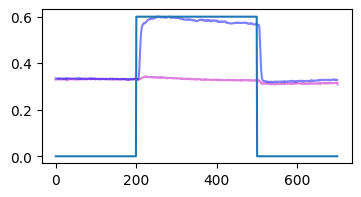

In [127]:
path = r'C:\Users\51325\Desktop\2024_summer_caltech\pid_test_20240717\zihang_behavior_only\log_test.txt'
path_2 = r'C:\Users\51325\Desktop\2024_summer_caltech\pid_test_20240717\zihang_behavior_only\PID_file_test.txt'
stimuli_info = get_stimuli(path)
pid_file = pd.read_csv(path_2,header= None)

df_0, df_1, df_2, df_3 = get_group_trial_info(stimuli_info,pid_file[1])


index_1 = get_index(df_1)
index_2 = get_index(df_2)


index_1_full = extend_index_ranges(index_1, 200)
index_2_full = extend_index_ranges(index_2, 200)

pre_w, during_w, post_w= split_trial_periods(index_1_full,pid_file[1])
pre_b, during_b, post_b= split_trial_periods(index_2_full,pid_file[1])

average_trial_w = get_average_trial(pre_w, during_w, post_w)
average_trial_b = get_average_trial(pre_b, during_b, post_b)

print(average_trial_w.shape)
print(average_trial_b.shape)

plt.figure(figsize=(4,2))

plt.plot(average_trial_w,'m',alpha=0.5, label ="49")
plt.plot(average_trial_b,'b',alpha=0.5, label = "48")

odor_on=np.zeros(len(average_trial_b))
odor_on[200:500]=0.6

plt.plot(odor_on)

# Example Usage

In [1]:
generation_summary_single_fly('2024_7_17_fly_1_CE')

print(7509/300*10/60)

NameError: name 'generation_summary_single_fly' is not defined

No files were successfully processed.


ValueError: x, y, and format string must not be None

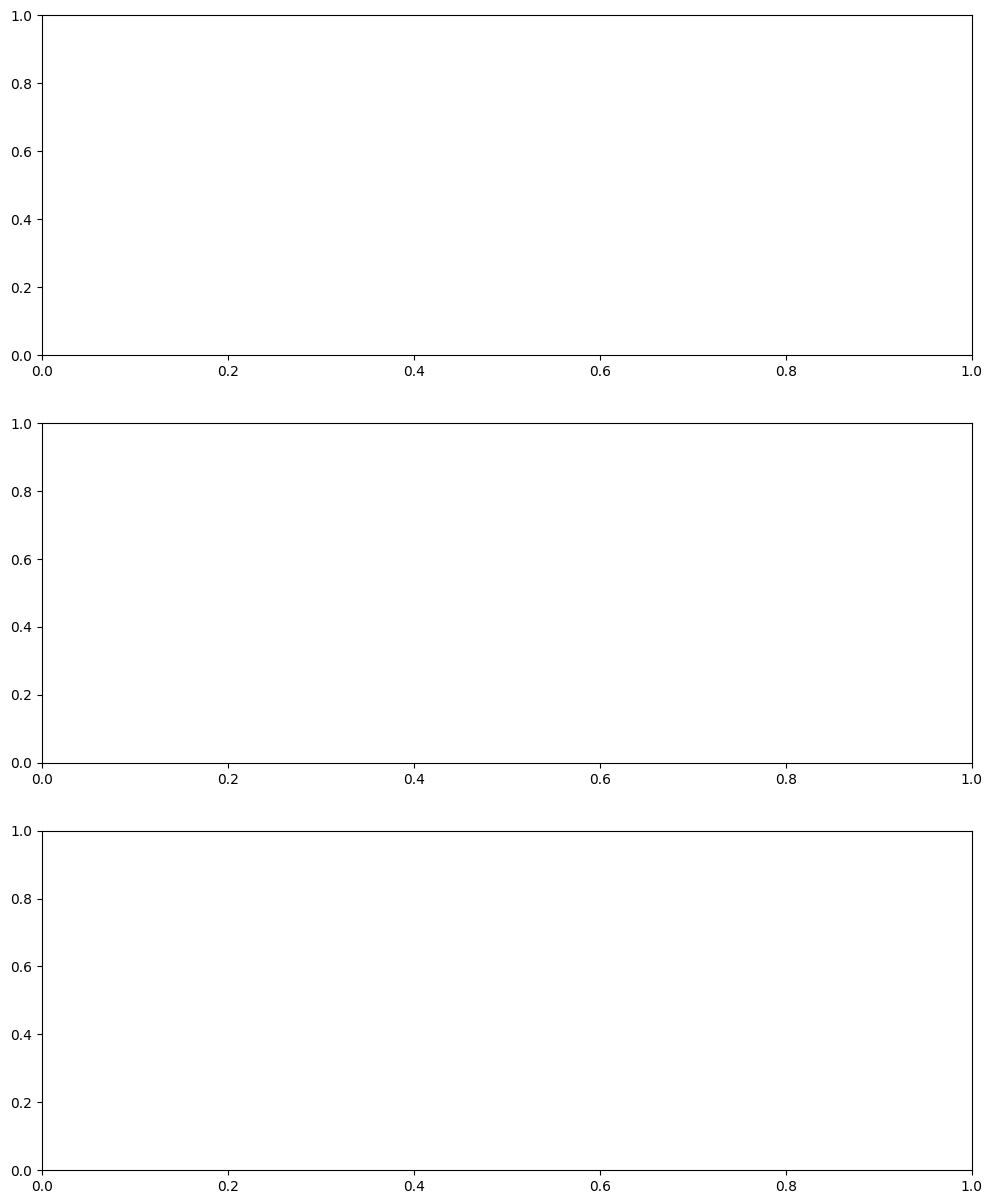

In [50]:
exposed_type = 'BE'
files=r'C:\Users\51325\Desktop\2024_summer_caltech'

BE_overall_x_vel_avg_w, BE_overall_x_vel_avg_b, BE_overall_y_vel_avg_w,BE_overall_y_vel_avg_b,BE_overall_vel_avg_w,BE_overall_vel_avg_b= average_within_folder(files,exposed_type)
plot_velocity_comparisons(BE_overall_x_vel_avg_w, BE_overall_x_vel_avg_b, BE_overall_y_vel_avg_w,BE_overall_y_vel_avg_b,BE_overall_vel_avg_w,BE_overall_vel_avg_b)


       start    end  pre_odor  post_odor
trial                                   
1       3905   4204      3405       4704
2       5707   6006      5207       6506
3      11113  11412     10613      11912
4      12915  13214     12415      13714
5      18321  18620     17821      19120
6      21925  22224     21425      22724
7      25529  25828     25029      26328
8      27331  27630     26831      28130
9      32737  33036     32237      33536
10     36341  36640     35841      37140
       start    end  pre_odor  post_odor
trial                                   
1       2103   2402      1603       2902
2       7509   7808      7009       8308
3      11113  11412     10613      11912
4      14717  15015     14217      15515
5      16518  16818     16018      17318
6      20123  20422     19623      20922
7      23727  24026     23227      24526
8      27331  27630     26831      28130
9      30935  31234     30435      31734
10     34539  34838     34039      35338
       start    

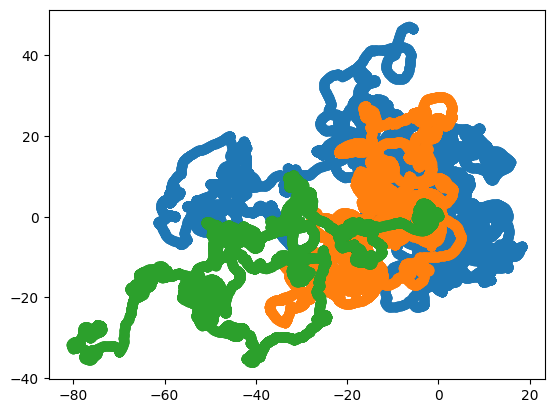

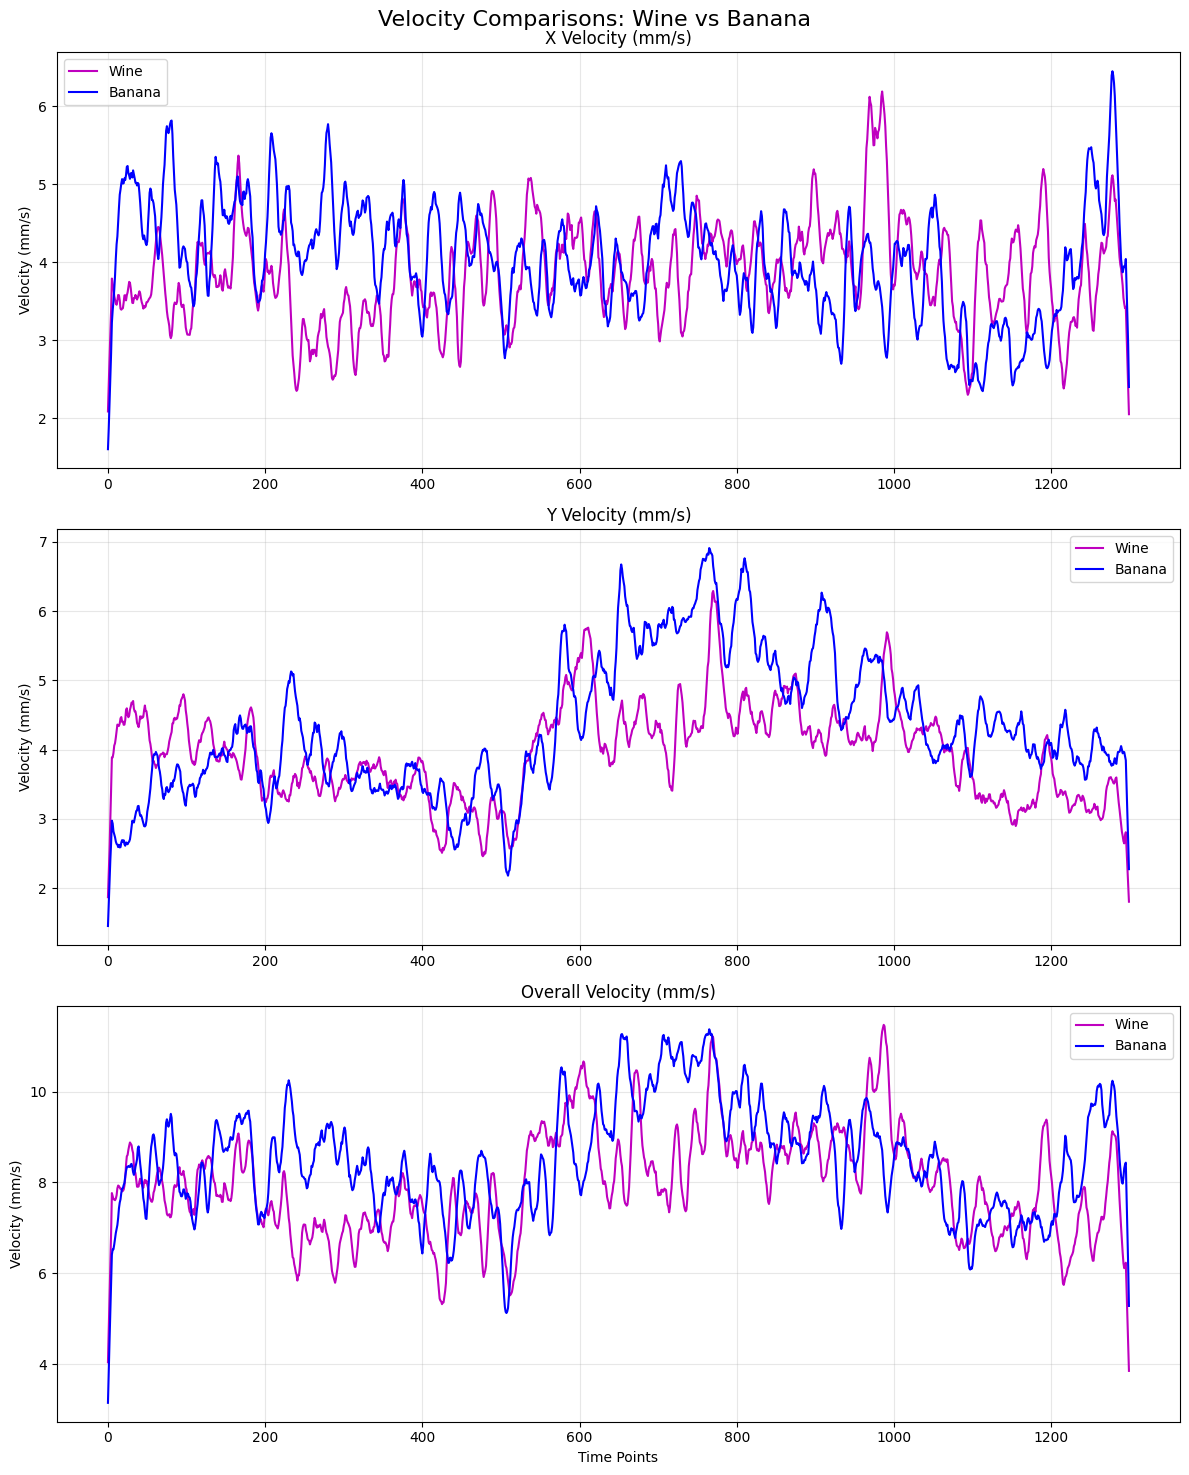

In [51]:
exposed_type = 'CE'

CE_overall_x_vel_avg_w, CE_overall_x_vel_avg_b, CE_overall_y_vel_avg_w,CE_overall_y_vel_avg_b,CE_overall_vel_avg_w,CE_overall_vel_avg_b= average_within_folder(files,exposed_type)

plot_velocity_comparisons(CE_overall_x_vel_avg_w, CE_overall_x_vel_avg_b, CE_overall_y_vel_avg_w,CE_overall_y_vel_avg_b,CE_overall_vel_avg_w,CE_overall_vel_avg_b)

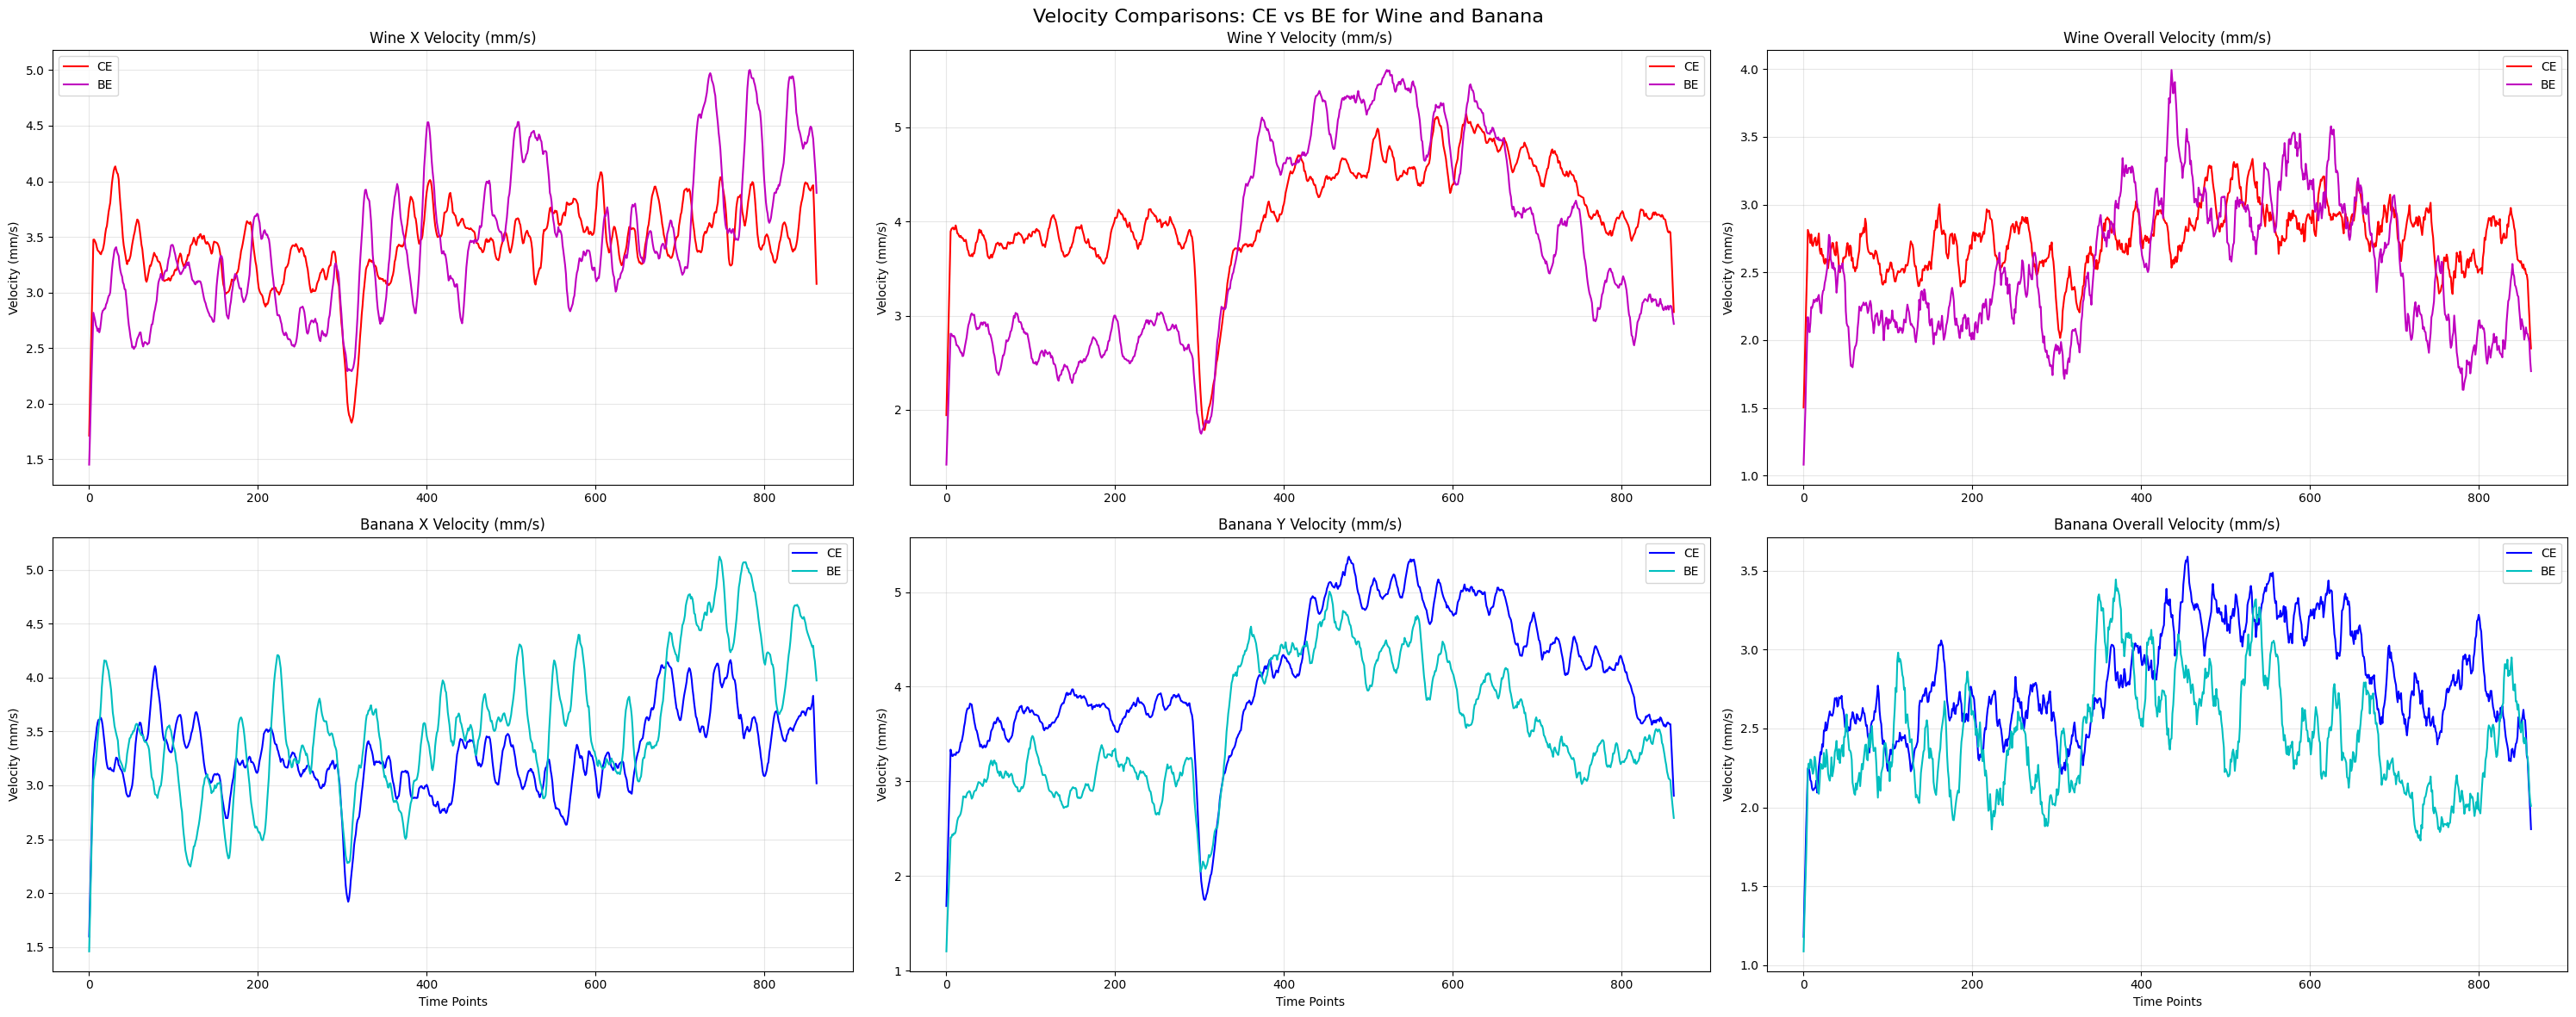

In [216]:

#this one is actually correct
plot_ce_be_comparisons(
    CE_overall_x_vel_avg_w, CE_overall_x_vel_avg_b, CE_overall_y_vel_avg_w, CE_overall_y_vel_avg_b, CE_overall_vel_avg_w, CE_overall_vel_avg_b,
    BE_overall_x_vel_avg_w, BE_overall_x_vel_avg_b, BE_overall_y_vel_avg_w, BE_overall_y_vel_avg_b, BE_overall_vel_avg_w, BE_overall_vel_avg_b
)
